## Exercise 1

In this exercise, I'm calculating the amount of bombs dropped by the Western Allies during the Second World War on contemporary German Federal States. The bombing dataset geospatial dataset was downloaded in .csv format from: https://data.world/datamil/world-war-ii-thor-data/workspace/file?filename=THOR_WWII_DATA_CLEAN.csv. The THOR dataset is compiled by the United States Air Force from digitized war-time flight records. More info: https://www.af.mil/News/Article-Display/Article/466817/historic-airpower-database-now-online/

Firstly I import the data, preform .crs transformations and manage the dataset. After these processing steams, I am aggregating the total tonnage of bombs dropped to contemporary German Federal States, downloaded from https://www.diva-gis.org/gdata (DEU_ADM1.shp). Finally, I'm the results as visualizing _tons of bombs per km2_ for each German Federal State in a choropleth map.

In [57]:
# Import required packages
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
from shapely import speedups
import numpy as np
import contextily as ctx

In [58]:
# Read input data
fp = r"data/THOR_WWII_DATA_CLEAN.csv"
data = pd.read_csv(fp, sep=",", encoding='latin1', low_memory=False)
fp = r"data/DEU_adm1.shp"
germany2020 = gpd.read_file(fp)

In [59]:
# Transform input dataframe into geodataframe
geo = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data["LONGITUDE"], data["LATITUDE"]))

In [60]:
# Check if "geo" GeoDataFrame has crs info
geo.crs

In [61]:
# Assign projection to "geo" GeoDataFrame
geo = geo.set_crs(epsg=4326)

# Reproject "geo" GeoDataFrame to metric
geo = geo.to_crs(epsg=32633)

# Reproject "germany2020" GeoDataFrame to metric
germany2020 = germany2020.to_crs(epsg=32633)

In [62]:
# Check that both map and geodataframe have same crs
geo.crs == germany2020.crs

True

In [63]:
# Drop unneccessary fields from "germany2020" GeoDataFrame
germany2020 = germany2020[["NAME_1", "geometry"]]

# Calculate land area for German Federal States
germany2020["area"] = germany2020["geometry"].area/10**6

In [64]:
# Check GeoDataFrame columns
geo.columns

Index(['WWII_ID', 'MASTER_INDEX_NUMBER', 'MSNDATE', 'THEATER', 'NAF',
       'COUNTRY_FLYING_MISSION', 'TGT_COUNTRY_CODE', 'TGT_COUNTRY',
       'TGT_LOCATION', 'TGT_TYPE', 'TGT_ID', 'TGT_INDUSTRY_CODE',
       'TGT_INDUSTRY', 'SOURCE_LATITUDE', 'SOURCE_LONGITUDE', 'LATITUDE',
       'LONGITUDE', 'UNIT_ID', 'MDS', 'AIRCRAFT_NAME', 'MSN_TYPE',
       'TGT_PRIORITY', 'TGT_PRIORITY_EXPLANATION', 'AC_ATTACKING', 'ALTITUDE',
       'ALTITUDE_FEET', 'NUMBER_OF_HE', 'TYPE_OF_HE', 'LBS_HE', 'TONS_OF_HE',
       'NUMBER_OF_IC', 'TYPE_OF_IC', 'LBS_IC', 'TONS_OF_IC', 'NUMBER_OF_FRAG',
       'TYPE_OF_FRAG', 'LBS_FRAG', 'TONS_OF_FRAG', 'TOTAL_LBS', 'TOTAL_TONS',
       'TAKEOFF_BASE', 'TAKEOFF_COUNTRY', 'TAKEOFF_LATITUDE',
       'TAKEOFF_LONGITUDE', 'AC_LOST', 'AC_DAMAGED', 'AC_AIRBORNE',
       'AC_DROPPING', 'TIME_OVER_TARGET', 'SIGHTING_METHOD_CODE',
       'SIGHTING_EXPLANATION', 'BDA', 'CALLSIGN', 'ROUNDS_AMMO',
       'SPARES_RETURN_AC', 'WX_FAIL_AC', 'MECH_FAIL_AC', 'MISC_FAIL_AC',
       

In [65]:
# Select required columns for further analysis
geo = geo[["geometry", "TOTAL_TONS"]]

<AxesSubplot:>

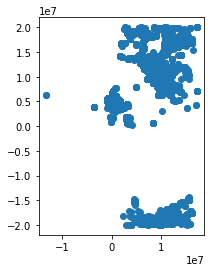

In [66]:
# Visually inspect data (notice outliers)
geo.plot()

In [67]:
# Select points within Germany Federal States and combine GeoDataFrames
ger_bombs = gpd.sjoin(geo, germany2020, op = 'within')

In [68]:
# Visually check combined GeoDataFrame
ger_bombs

,geometry,TOTAL_TONS,index_right,NAME_1,area
11,POINT (392821.289 5821161.996),1.0,2,Berlin,884.865524
12,POINT (392821.289 5821161.996),4.0,2,Berlin,884.865524
651,POINT (392821.289 5821161.996),1.0,2,Berlin,884.865524
652,POINT (392821.289 5821161.996),6.0,2,Berlin,884.865524
1239,POINT (392821.289 5821161.996),1.0,2,Berlin,884.865524
...,...,...,...,...,...
177674,POINT (317476.732 5689782.432),28.0,13,Sachsen,18410.690209
177675,POINT (317476.732 5689782.432),30.0,13,Sachsen,18410.690209
177676,POINT (317476.732 5689782.432),30.0,13,Sachsen,18410.690209
177677,POINT (317476.732 5689782.432),30.0,13,Sachsen,18410.690209


In [69]:
# Select only required columns for further analysis
ger_bombs = ger_bombs[["geometry", "TOTAL_TONS", "NAME_1", "area"]]

In [70]:
# Drop rows containing NaN values
ger_bombs = ger_bombs.dropna()

<AxesSubplot:>

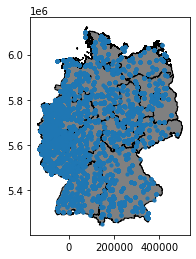

In [71]:
# Visually inspect data
ax = germany2020.plot(facecolor="gray", edgecolor="black")
ger_bombs.plot(ax=ax, markersize=10)

In [72]:
## Data aggregation and calculation
# Aggregate TOTAL_TONS values for each German Federal state
bombs_by_state = ger_bombs.groupby("NAME_1").agg({"TOTAL_TONS" : "sum"})

# Join 
join = germany2020.merge(bombs_by_state, on="NAME_1")

In [73]:
# Calculate total tons per land area
join["TONS_PER_KM2"] = join["TOTAL_TONS"] / join["area"]

In [74]:
# Visually inspect aggregated dataset
join

,NAME_1,geometry,area,TOTAL_TONS,TONS_PER_KM2
0,Baden-Württemberg,"MULTIPOLYGON (((28189.137 5303887.952, 28230.4...",35864.107394,134087.0,3.738752
1,Bayern,"POLYGON ((155332.447 5611099.265, 155698.436 5...",70541.366060,203571.5,2.885846
2,Berlin,"POLYGON ((376007.307 5806014.243, 375181.687 5...",884.865524,104413.0,117.998721
3,Brandenburg,"POLYGON ((425678.204 5928596.809, 425659.173 5...",29445.079889,33663.0,1.143247
4,Bremen,"MULTIPOLYGON (((66735.460 5917886.615, 67532.9...",394.266504,56197.0,142.535568
5,Hamburg,"POLYGON ((174889.422 5963456.014, 174910.249 5...",769.588709,64123.0,83.321129
6,Hessen,"POLYGON ((119379.112 5734401.962, 119761.886 5...",21059.361798,164565.0,7.814339
7,Mecklenburg-Vorpommern,"MULTIPOLYGON (((451469.753 5951585.048, 451469...",23191.726339,44964.0,1.938795
8,Niedersachsen,"MULTIPOLYGON (((-37838.503 5969389.249, -37842...",47842.444284,182479.0,3.814165
9,Nordrhein-Westfalen,"POLYGON ((70522.351 5838336.646, 70890.392 583...",34474.622738,547392.0,15.878114


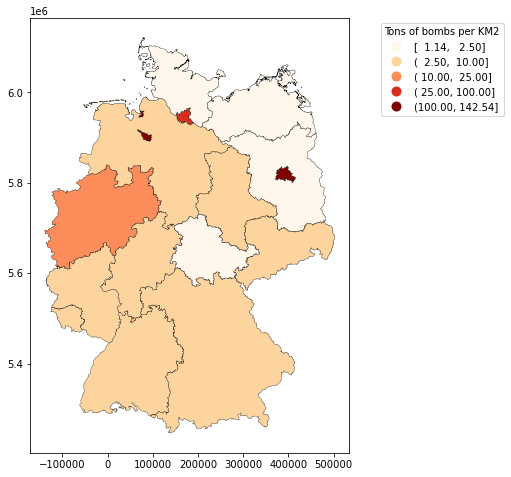

In [75]:
## Plotting
# Adjust figure size
fig, ax = plt.subplots(1, figsize=(10, 8))

# Adjust colors and add a legend
#join.plot(ax=ax, column="TONS_PER_KM2", cmap="OrRd", legend=True, edgecolor='black', linewidth=0.3)
#normalize = matplotlib.colors.Normalize(vmin=join["TONS_PER_KM2"].min(), vmax=join["TONS_PER_KM2"].max())
join.plot(ax=ax, column="TONS_PER_KM2", legend=True, edgecolor='black', cmap="OrRd", scheme='user_defined', classification_kwds={'bins':[ 2.5, 10, 25, 100, join["TONS_PER_KM2"].max()]}, linewidth=0.3)

join["TONS_PER_KM2"].min()

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.5,1))
ax.get_legend().set_title("Tons of bombs per KM2")

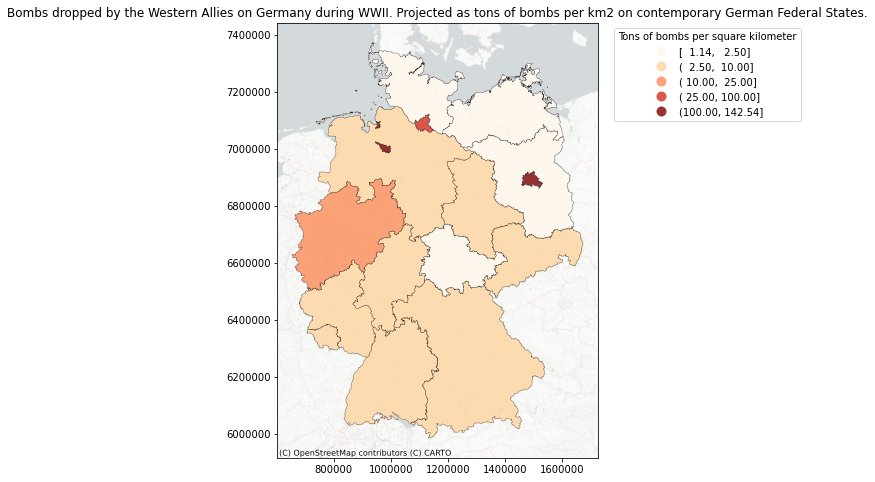

In [76]:
# Reproject to EPSG 3857 to be compatible with basemaps
join_wgs84 = join.to_crs(epsg=3857)

# Adjust figure size
fig, ax = plt.subplots(1, figsize=(15, 8))

# Plot the map and add a legend
join_wgs84.plot(ax=ax, column="TONS_PER_KM2",
                legend=True, edgecolor='black',
                cmap="OrRd", scheme='user_defined',
                linewidth=0.3, alpha=0.8,
                
                # Apply user defined classification to the bombing map
                classification_kwds={'bins':[ 2.5, 10, 25, 100, join["TONS_PER_KM2"].max()]})

# Adjust x axis label style
ax.ticklabel_format(style="plain")
# Set map title
plt.title("Bombs dropped by the Western Allies on Germany during WWII. Projected as tons of bombs per km2 on contemporary German Federal States.")

# Re-position the legend and set a title
ax.get_legend().set_bbox_to_anchor((1.65,1))
ax.get_legend().set_title("Tons of bombs per square kilometer")

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)


In [78]:
output = "docs/Exercise1"
fig.savefig(output)